In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import json

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
test_model_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_test1/'

In [3]:
# Load model
model = tf.keras.models.load_model(os.path.join(test_model_path, 'CMA_0'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 128)     0

In [4]:
# Load model_predictions
with open(os.path.join(test_model_path, 'targets_CMA_0.csv'), 'r') as file:
    targets_df = pd.read_csv(file)
    mask = targets_df.set == 'test'
    targets_df = targets_df[~mask]
# Sort by abs difference between y and y_hat
targets_df.loc[targets_df['y - y_hat'].abs().argsort()]

y       y_hat  mapobject_id_cell    set   y - y_hat  \
2549  405.562714  405.558167             258533  train    0.004547   
2643  324.310883  324.318146             331807  train   -0.007263   
3117  310.374542  310.365173             295709    val    0.009369   
1890  336.368744  336.319794             278713  train    0.048950   
2810  326.268768  326.321960             291586  train   -0.053192   
...          ...         ...                ...    ...         ...   
3059  644.971497  511.101013             262901    val  133.870483   
2921  537.458374  401.915192             359417  train  135.543182   
2889  523.743408  384.663605             378157  train  139.079803   
2713  207.263077  361.649200             202813  train -154.386124   
2331  519.404358  364.881439             275864  train  154.522919   

     perturbation cell_cycle  
2549       normal          S  
2643       normal         G1  
3117         DMSO         G1  
1890       normal         G1  
2810       normal         G1  
...           ...        ...  
3059       normal         G2  
2921         DMSO          S  
2889       normal         G1  
2713       normal         G1  
2331       normal         G1  

[3332 rows x 7 columns]

In [5]:
# Load parameters
with open(os.path.join(test_model_path, 'parameters.json'), 'r') as file:
    p = json.load(file)
p.keys()

dict_keys(['_comment', 'model_path', 'model_dir', 'clean_model_dir', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'CenterZoom', 'CenterZoom_mode', 'disable_gpu', 'set_memory_growth', 'model_name', 'pre_training', 'conv_reg', 'dense_reg', 'verbose_level', 'number_of_epochs', 'loss', 'learning_rate', 'BATCH_SIZE', 'log_file_name', 'log_level', 'tensorboard', 'seed', 'input_channels', 'parameters_file_path'])

In [6]:
# Load channels
with open(os.path.join(test_model_path, 'channels.csv'), 'r') as file:
    channels_df = pd.read_csv(file)
# Get input channel ids
mask = channels_df.name.isin(p['input_channels'])
channel_ids = channels_df[mask].channel_id.values
# Get output channel id
mask = channels_df.name == '00_EU'
output_id = channels_df[mask].channel_id.values[0]
# Get normalization values
norm_vals = channels_df.sort_values(by=['channel_id']).normalization_vals.values

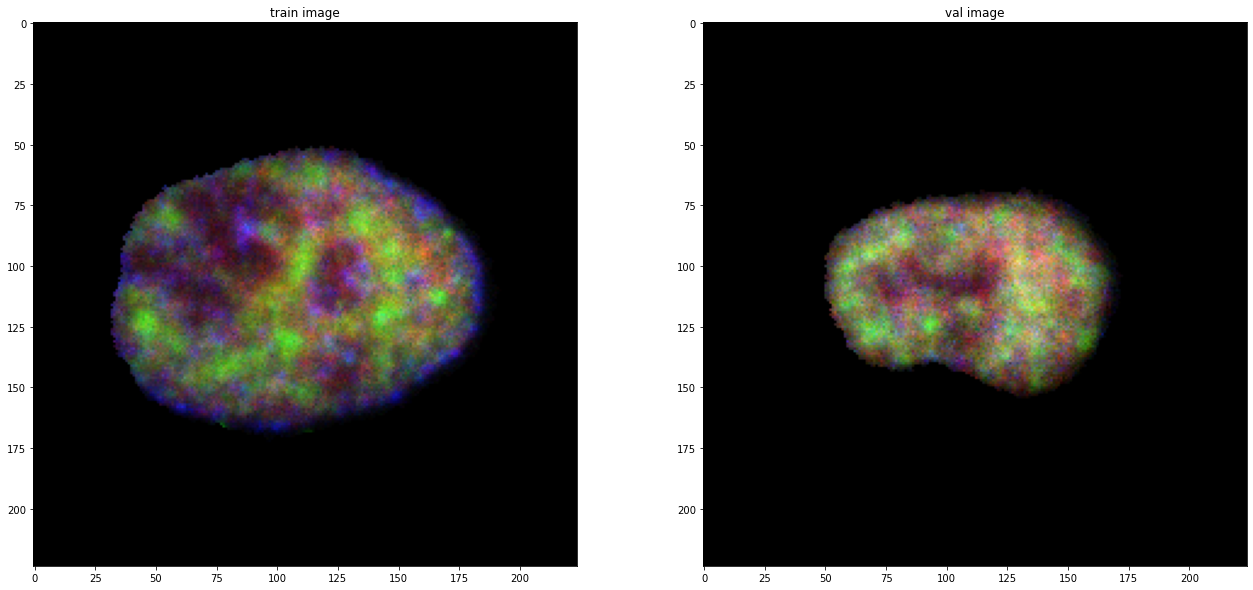

In [42]:
# select one element from train and val to get the IG
train_cell = np.load(os.path.join(test_model_path, 'Cells', '258533.npz'))
train_img = train_cell['img'] / norm_vals
train_img = train_img[:,:,channel_ids].astype(np.float32)
train_target = train_cell['targets']

val_cell = np.load(os.path.join(test_model_path, 'Cells', '295709.npz'))
val_img = val_cell['img'] / norm_vals
val_img = val_img[:,:,channel_ids].astype(np.float32)
val_target = val_cell['targets']

# Now take a look into its image

temp_img = (train_img / np.max(train_img, axis=(0,1)))[:,:,10:13]
plt.figure(figsize=(2*11,10))
plt.subplot(1,2,1)
plt.imshow(temp_img,
           cmap=plt.cm.PiYG,
           #norm=True,
           aspect='equal'
          )
plt.title('train image')

temp_img = (val_img / np.max(val_img, axis=(0,1)))[:,:,10:13]
plt.subplot(1,2,2)
plt.imshow(temp_img,
           cmap=plt.cm.PiYG,
           #norm=True,
           aspect='equal'
          )
plt.title('val image')
plt.show()

In [8]:
# Sanity check: compute y_hat given the image
train_tensor = tf.convert_to_tensor(train_img, dtype=tf.float32)
train_tensor = tf.expand_dims(train_tensor, axis=0)
print(model.predict(train_tensor)[0][0], train_target[output_id])

405.55716 405.5627106983144


In [9]:
mask = (targets_df.mapobject_id_cell == 258533)
targets_df[mask]

y       y_hat  mapobject_id_cell    set  y - y_hat  \
2549  405.562714  405.558167             258533  train   0.004547   

     perturbation cell_cycle  
2549       normal          S

In [10]:
# Sanity check: compute y_hat given the image
val_tensor = tf.convert_to_tensor(val_img, dtype=tf.float32)
val_tensor = tf.expand_dims(val_tensor, axis=0)
print(model.predict(val_tensor)[0][0], val_target[output_id])

310.3597 310.3745313671582


In [11]:
mask = (targets_df.mapobject_id_cell == 295709)
targets_df[mask]

y       y_hat  mapobject_id_cell  set  y - y_hat perturbation  \
3117  310.374542  310.365173             295709  val   0.009369         DMSO   

     cell_cycle  
3117         G1

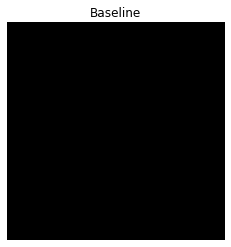

In [12]:
n_channels = train_img.shape[-1]
baseline = tf.zeros(shape=(224,224,n_channels))
plt.imshow(baseline[:,:,0:3])
plt.title("Baseline")
plt.axis('off')
plt.show()

In [13]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [14]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    
    return images

In [15]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=train_img,
    alphas=alphas)

In [16]:
interpolated_images.shape

TensorShape([51, 224, 224, 33])

In [17]:
interpolated_images[0::10].shape

TensorShape([6, 224, 224, 33])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


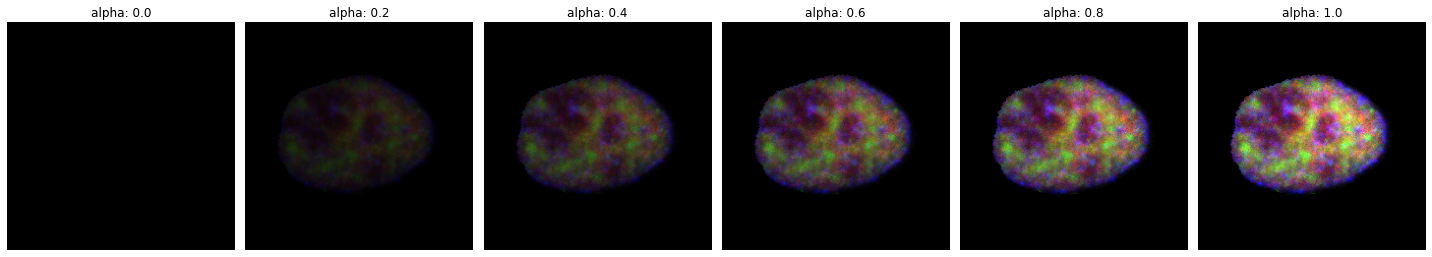

In [18]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image[:,:,10:13])
    plt.axis('off')

plt.tight_layout();

In [19]:
def compute_gradients(images):
    with tf.GradientTape() as tape:
        tape.watch(images)
        prediction = model(images)
    
    return tape.gradient(prediction, images)

In [20]:
path_gradients = compute_gradients(
    images=interpolated_images)

In [21]:
path_gradients.shape

TensorShape([51, 224, 224, 33])

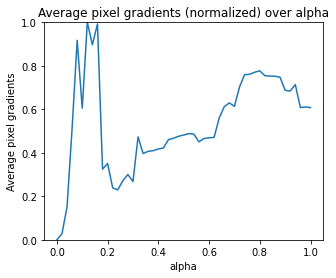

In [22]:
pred = model(interpolated_images)

plt.figure(figsize=(5, 4))

# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
plt.plot(alphas, average_grads_norm)
plt.title('Average pixel gradients (normalized) over alpha')
plt.ylabel('Average pixel gradients')
plt.xlabel('alpha')
plt.ylim([0, 1]);

In [23]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    
    return integrated_gradients

In [24]:
ig = integral_approximation(
    gradients=path_gradients)
print(ig.shape)

(224, 224, 33)


In [25]:
@tf.function
def integrated_gradients(baseline, image, m_steps=50, batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    
    # Initialize TensorArray outside loop to collect gradients.
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        
        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)
        
        # 3. Compute gradients between model outputs and interpolated inputs.
        gradient_batch = compute_gradients(images=interpolated_path_input_batch)
        
        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)
    
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()
    
    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    
    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients
    
    return integrated_gradients

In [26]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=train_img,
                                       m_steps=240)

In [27]:
print(ig_attributions.shape)

(224, 224, 33)


In [33]:
def plot_img_attributions(baseline,
                          image,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
    
    attributions = integrated_gradients(baseline=baseline,
                                        image=image,
                                        m_steps=m_steps)
    
    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))
    
    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline[:,:,0:3])
    axs[0, 0].axis('off')
    
    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image[:,:,10:13])
    axs[0, 1].axis('off')
    
    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')
    
    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image[:,:,10:13], alpha=overlay_alpha)
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


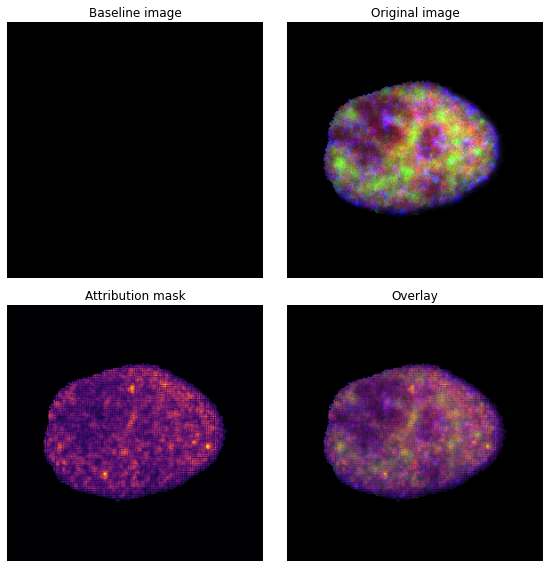

In [34]:
_ = plot_img_attributions(image=train_img,
                          baseline=baseline,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


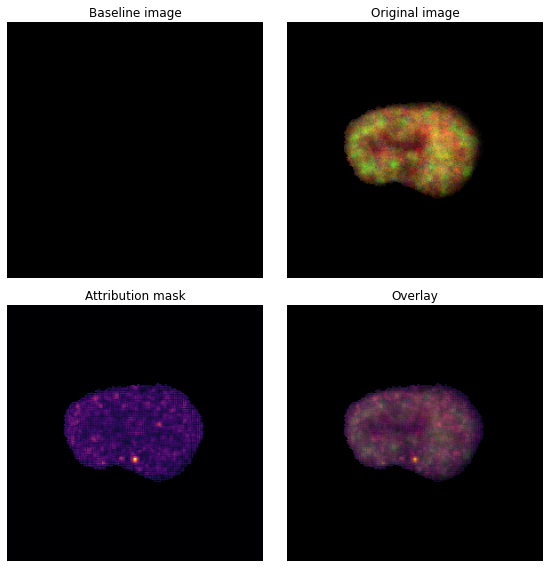

In [35]:
_ = plot_img_attributions(image=val_img,
                          baseline=baseline,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [118]:
train_scors = integrated_gradients(baseline=baseline, image=train_img, m_steps=240)
train_scors.shape

TensorShape([224, 224, 33])

In [119]:
temp_tensor = tf.expand_dims(train_scors, axis=0)
ig_sample = temp_tensor
ig_sample = tf.concat((ig_sample, temp_tensor), axis=0)
ig_sample = tf.concat((ig_sample, temp_tensor), axis=0)

ig_sample.shape

TensorShape([3, 224, 224, 33])

In [120]:
tf.math.reduce_std(ig_sample, axis=0).shape

TensorShape([224, 224, 33])

In [114]:
np.unique(train_scors[:,:,0].numpy())

array([-0.09074974, -0.08111566, -0.0797158 , ...,  0.03094102,
        0.03309422,  0.03357993], dtype=float32)

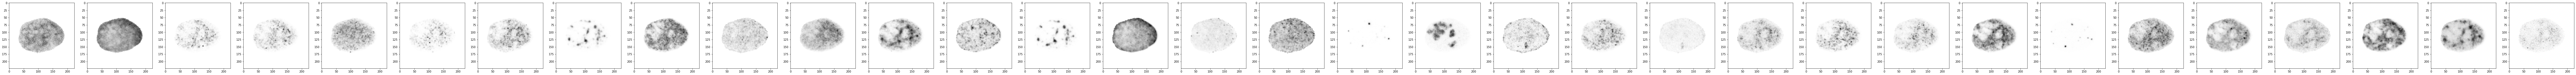

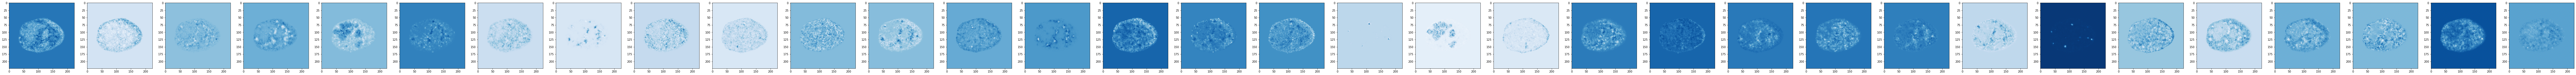

In [78]:
n_channels = train_img.shape[-1]

plt.figure(figsize=(n_channels*5.1, 5))

for c in range(n_channels):
    plt.subplot(1,n_channels, c+1)
    plt.imshow(train_img[:,:,c],
               cmap=plt.cm.Greys,
               #norm=True,
               aspect='equal'
              )
    
plt.figure(figsize=(n_channels*5.1, 5))
for c in range(n_channels):
    plt.subplot(1,n_channels, c+1)
    plt.imshow(train_scors[:,:,c],
               cmap=plt.cm.Blues,
               #vmin=0, vmax=1,
               #norm=True,
               aspect='equal'
              )

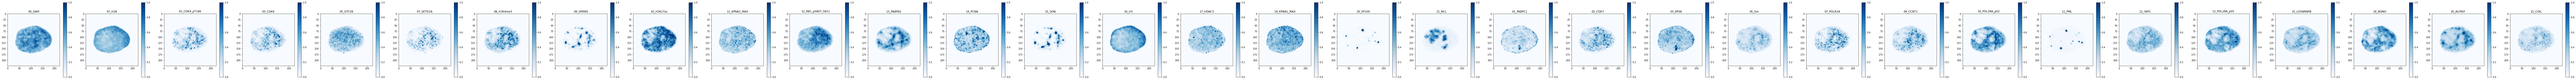

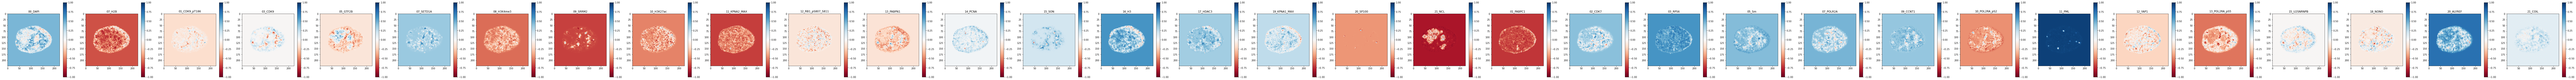

In [103]:
temp_scor = train_scors.numpy()
# move to [0,1]
max_val = temp_scor.max(axis=(0,1))
min_val = temp_scor.min(axis=(0,1))
temp_scor = (temp_scor - min_val) / (max_val - min_val)
# move to [-1,1]
temp_scor = -1 + 2*temp_scor

n_channels = train_img.shape[-1]

plt.figure(figsize=(n_channels*6.1, 6))

for c in range(n_channels):
    channel_name = channels_df['name'][channels_df.channel_id == c].values[0]
    plt.subplot(1,n_channels, c+1)
    img = plt.imshow(train_img[:,:,c],
               cmap=plt.cm.Blues,
               vmin=0, vmax=1,
               #norm=True,
               aspect='equal'
              )
    plt.title(channel_name)
    plt.colorbar(img)
    
plt.figure(figsize=(n_channels*6.1, 6))
for c in range(n_channels):
    channel_name = channels_df['name'][channels_df.channel_id == c].values[0]
    plt.subplot(1,n_channels, c+1)
    img = plt.imshow(temp_scor[:,:,c],
               cmap=plt.cm.RdBu,
               vmin=-1, vmax=1,
               #norm=True,
               aspect='equal'
              )
    plt.title(channel_name)
    plt.colorbar(img)

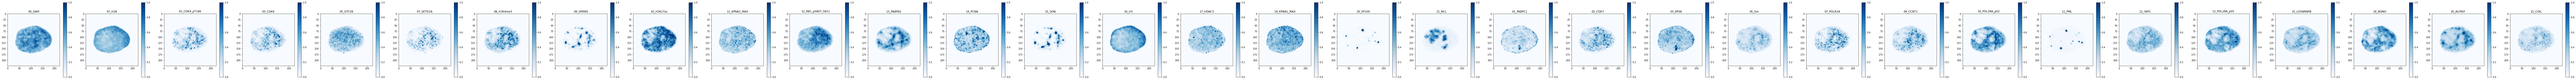

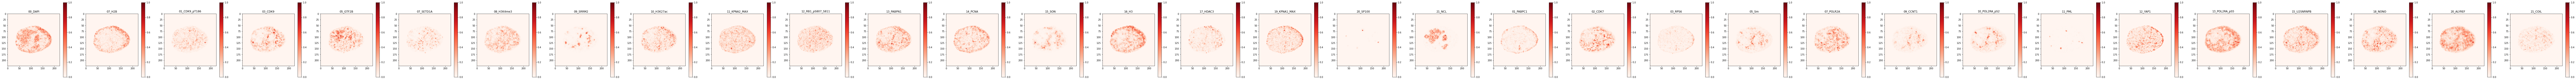

In [117]:
temp_scor = train_scors.numpy()
temp_scor = np.abs(temp_scor)
# move to [0,1]
max_val = temp_scor.max(axis=(0,1))
min_val = temp_scor.min(axis=(0,1))
temp_scor = (temp_scor - min_val) / (max_val - min_val)

n_channels = train_img.shape[-1]

plt.figure(figsize=(n_channels*6.1, 6))

for c in range(n_channels):
    channel_name = channels_df['name'][channels_df.channel_id == c].values[0]
    plt.subplot(1,n_channels, c+1)
    img = plt.imshow(train_img[:,:,c],
               cmap=plt.cm.Blues,
               vmin=0, vmax=1,
               #norm=True,
               aspect='equal'
              )
    plt.title(channel_name)
    plt.colorbar(img)
    
plt.figure(figsize=(n_channels*6.1, 6))
for c in range(n_channels):
    channel_name = channels_df['name'][channels_df.channel_id == c].values[0]
    plt.subplot(1,n_channels, c+1)
    img = plt.imshow(temp_scor[:,:,c],
               cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               #norm=True,
               aspect='equal'
              )
    plt.title(channel_name)
    plt.colorbar(img)